In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 15
num_classes = 10
batch_size = 60
learning_rate = 0.001
h_dim =100
z_dim=10

In [2]:
dataset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transforms.ToTensor())
print("data : " + str(len(dataset)) + ' images')

dataloader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
classes= ('0','1','2','3','4','5','6','7','8','9')

data : 60000 images


GroundTruth:      9     7     5     8     2     9     0     6     8     1     3     9     6     5     5     4     3     0     1     3     0     9     0     1     5     2     7     8     3     9     6     5     8     4     5     5     8     1     1     1     2     4     1     6     0     9     4     4     5     3     7     2     4     0     9     0     2     6     3     3


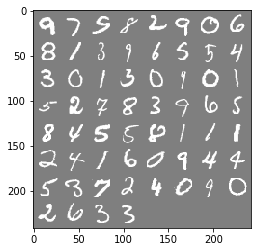

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion() 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images,labels=iter(dataloader).next()
# plt.imshow(torch.squeeze(images[0]))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

image_size=images.size(2)*images.size(3)


In [4]:
#VAE Model

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim,z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim,image_size)
        
    def encode(self, x):
        x=F.relu(self.fc1(x))
        mu=self.fc2(x)
        var=self.fc3(x)
        return mu, var
        
    def reparameterize(self, mu, var):
        std = torch.exp(var/2)
        eps = torch.randn_like(std)
        return mu + eps * std        
        
    def decode(self, x):
        x=F.relu(self.fc4(x))
        out=self.fc5(x)
        return F.sigmoid(out)

        
    def forward(self, x):
        mu,var = self.encode(x)
        z = self.reparameterize(mu, var)
        out = self.decode(z)
        return out,mu,var#,resp2,resp2,resp4
                        

model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=784, bias=True)
)


In [5]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


In [6]:
#Training
def train(epoch, trainloader, optimizer):
    running_loss = 0.0
    
    for i, (x,_) in enumerate(tqdm(dataloader), 0):
        x = x.to(device)
        x= x.view(-1, image_size)
        x_reconst, mu, var=model(x)
              
        optimizer.zero_grad()
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
        loss = reconst_loss + kl_div

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('epoch %d Loss: %f, Reconst Loss: %f, KL Div: %f' % (epoch + 1, loss, reconst_loss, kl_div ))
    return running_loss / (len(dataloader))    



In [7]:
import os
from tqdm import tqdm
print('Start Training')

training_losses = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    loss = train(epoch, dataloader, optimizer)
    
    training_losses.append(loss)

print('Finished Training')


  0%|          | 0/1000 [00:00<?, ?it/s]

Start Training
epoch  1


/home/athira/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/athira/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 13/1000 [00:00<00:07, 127.52it/s]

epoch 1 Loss: 8269.414062, Reconst Loss: 7320.241699, KL Div: 949.172546
epoch  2


  1%|▏         | 14/1000 [00:00<00:07, 131.35it/s]

epoch 2 Loss: 7935.007812, Reconst Loss: 6999.725586, KL Div: 935.282227
epoch  3


  1%|▏         | 13/1000 [00:00<00:08, 121.71it/s]

epoch 3 Loss: 7191.459473, Reconst Loss: 6194.991211, KL Div: 996.468384
epoch  4


  1%|          | 11/1000 [00:00<00:09, 109.65it/s]

epoch 4 Loss: 7045.936523, Reconst Loss: 6031.749023, KL Div: 1014.187378
epoch  5


  1%|▏         | 13/1000 [00:00<00:08, 122.20it/s]

epoch 5 Loss: 7380.141602, Reconst Loss: 6399.728516, KL Div: 980.413208
epoch  6


  1%|▏         | 13/1000 [00:00<00:07, 127.50it/s]

epoch 6 Loss: 7232.603027, Reconst Loss: 6169.724609, KL Div: 1062.878418
epoch  7


  1%|▏         | 13/1000 [00:00<00:07, 125.02it/s]

epoch 7 Loss: 6696.062500, Reconst Loss: 5738.035645, KL Div: 958.026672
epoch  8


  1%|▏         | 13/1000 [00:00<00:07, 128.18it/s]

epoch 8 Loss: 6779.289551, Reconst Loss: 5785.116699, KL Div: 994.172729
epoch  9


  1%|▏         | 13/1000 [00:00<00:07, 123.78it/s]

epoch 9 Loss: 7385.541992, Reconst Loss: 6328.522949, KL Div: 1057.019043
epoch  10


  1%|▏         | 13/1000 [00:00<00:07, 125.26it/s]

epoch 10 Loss: 7047.047852, Reconst Loss: 5984.998047, KL Div: 1062.049805
epoch  11


  1%|▏         | 14/1000 [00:00<00:07, 130.74it/s]

epoch 11 Loss: 7056.514648, Reconst Loss: 6004.156250, KL Div: 1052.358154
epoch  12


  1%|▏         | 13/1000 [00:00<00:07, 129.18it/s]

epoch 12 Loss: 6996.030273, Reconst Loss: 5959.982422, KL Div: 1036.047607
epoch  13


  1%|▏         | 13/1000 [00:00<00:07, 128.36it/s]

epoch 13 Loss: 6835.618652, Reconst Loss: 5777.637207, KL Div: 1057.981323
epoch  14


  1%|▏         | 13/1000 [00:00<00:07, 126.69it/s]

epoch 14 Loss: 6941.711914, Reconst Loss: 5872.302734, KL Div: 1069.409302
epoch  15


100%|██████████| 1000/1000 [00:07<00:00, 135.72it/s]

epoch 15 Loss: 6812.658203, Reconst Loss: 5758.052246, KL Div: 1054.606201
Finished Training


In [8]:
# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


/home/athira/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

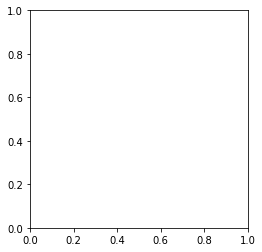

In [19]:
z=torch.randn(1,z_dim).to(device)
out=model.decode(z).view(1,28,28)


RuntimeError: size mismatch, m1: [1680 x 28], m2: [784 x 100] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

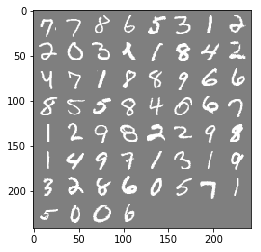

In [21]:
x,_=iter(dataloader).next()
x.shape
imshow(torchvision.utils.make_grid(x))
x = x.to(device)
out,_,_=model(x)
# x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)